<a href="https://colab.research.google.com/github/jiw3026/DL_NLP_CODE/blob/main/07_%E1%84%8B%E1%85%A9%E1%84%83%E1%85%B5%E1%84%8B%E1%85%A9%E1%84%8C%E1%85%A5%E1%86%AB%E1%84%8E%E1%85%A5%E1%84%85%E1%85%B5_%E1%84%86%E1%85%B5%E1%86%BE_%E1%84%80%E1%85%A1%E1%86%AB%E1%84%83%E1%85%A1%E1%86%AB%E1%84%92%E1%85%A1%E1%86%AB_%E1%84%87%E1%85%AE%E1%86%AB%E1%84%85%E1%85%B2_%E1%84%8B%E1%85%A1%E1%86%A8%E1%84%80%E1%85%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오디오 분류(Audio Classification)

* 가상 악기를 활용해 악기별 음색 데이터셋을 활용해 오디오 분류

1. 기존 데이터에서 분류에 사용되는 방법을 사용해 분류
2. 오디오 데이터에 특화된 분류

* 출처: https://bab2min.tistory.com/642

### 데이터 준비 및 전처리

In [ ]:
import numpy as np
import itertools 
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

* 데이터를 저장할 리스트와 파일을 불러올 경로를 지정

* https://s3.ap-northeast-2.amazonaws.com/suanlab.com/dataset/GeneralMidi.wav



In [ ]:
!pip install -U --no-cache-dir gdown --pre

In [ ]:
!gdown --id 1r703a_qF7sbPfHnKCJqASi-zc81aZTtd

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1r703a_qF7sbPfHnKCJqASi-zc81aZTtd
To: /content/GeneralMidi.wav
100% 3.41G/3.41G [00:29<00:00, 117MB/s]


In [ ]:
midi_file = '/content/GeneralMidi.wav'

* wav 파일에는 128개 악기와 46개 타악기의 음을 50개씩 2초 간격으로 존재
* 해당 예제에서는 일부 악기만 선택해서 사용

In [ ]:
np.random.seed(7)
instruments = np.random.randint(0, 100, 10)
instruments

array([47, 68, 25, 67, 83, 23, 92, 57, 14, 23])

- librasa load : https://librosa.org/doc/main/generated/librosa.load.html 

    - Load an audio file as a floating point time series.
    - input : librosa.load(path, *, sr=22050, mono=True, offset=0.0, duration=None, dtype=<class 'numpy.float32'>, res_type='kaiser_best')
    - output : y(audio time series), sr(sample rate)


In [ ]:
num_notes = 50
sec = 2

audio = []
inst = [] 

for inst_idx, note in itertools.product(range(len(instruments)), range(num_notes)):
    
    # 악기 인덱스
    instrument = instruments[inst_idx]

    # sound 시작 지점 
    offset = (instrument*num_notes*sec) + (note*sec)  # 악기 소리 시작 지점 + Note 시작 지점 
    print("instrument : {}, note:{}, offset:{}".format(instrument, note, offset))

    # librosa load 
    y, sr = librosa.load(midi_file, sr = None, offset = offset, duration =2.0)

    audio.append(y)
    inst.append(inst_idx)

In [ ]:
import numpy as np

audio_np = np.array(audio, np.float32)
inst_np = np.array(inst, np.int16)


#  10개의 악기*50개의 음계
print(audio_np.shape, inst_np.shape)

(500, 88200) (500,)


In [ ]:
audio_np[0]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [ ]:
inst_np[0]

0

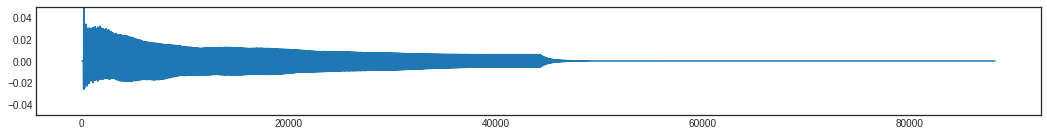

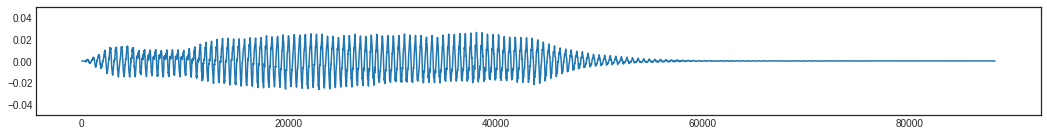

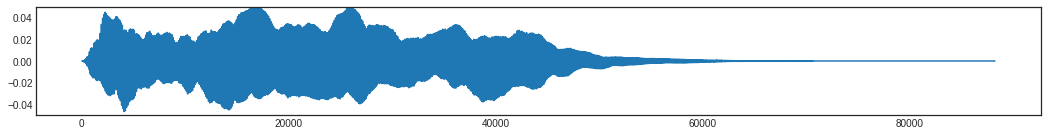

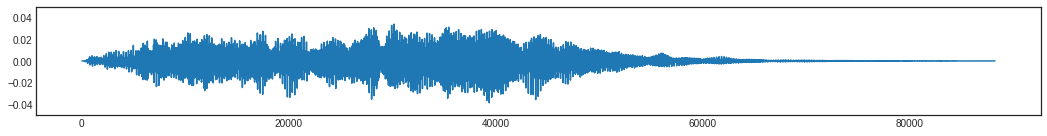

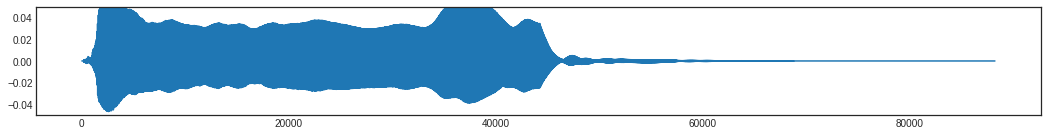

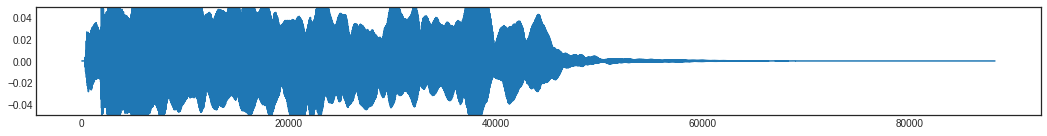

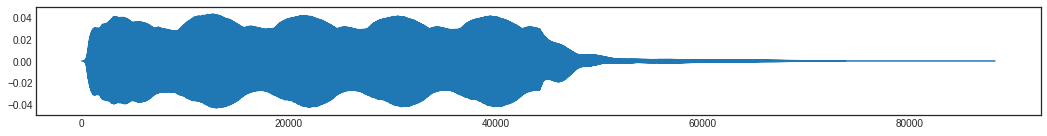

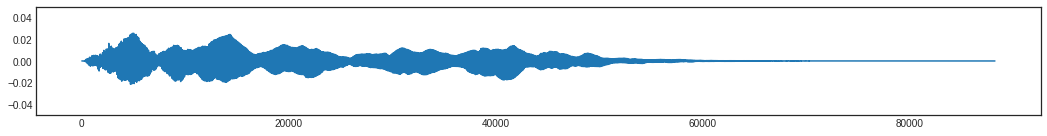

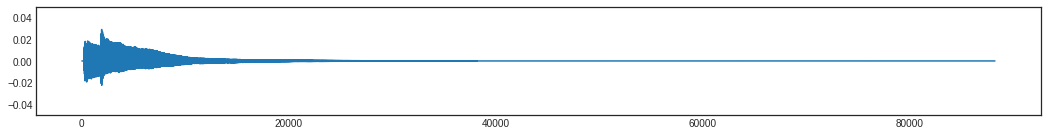

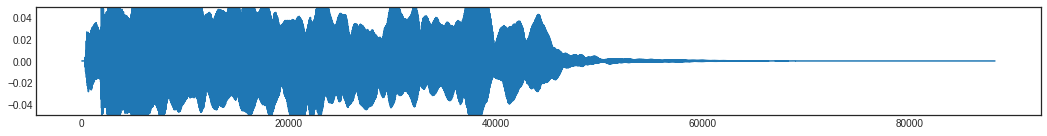

In [ ]:
for idx in range(0, len(audio_np), num_notes):
    plt.figure(figsize=(18, 2))
    plt.plot(audio_np[idx])
    plt.ylim(-0.05, 0.05)
    plt.show()

In [ ]:
sr

44100

In [ ]:
import IPython.display as ipd 

ipd.Audio(audio_np[-1], rate = sr)

librosa 패키지는 함수의 입력으로 -1 ~ 1 사이의 데이터를 처리하기 때문에 스케일링이 필요함

In [ ]:
from sklearn.preprocessing import MinMaxScaler 

scaler = MinMaxScaler()
scaler.fit_transform(audio_np)

array([[0.5555556 , 0.625     , 0.5555556 , ..., 0.71428573, 0.625     ,
        0.5555556 ],
       [0.5555556 , 0.625     , 0.5555556 , ..., 0.42857143, 0.375     ,
        0.33333337],
       [0.33333337, 0.375     , 0.33333337, ..., 0.42857143, 0.375     ,
        0.33333337],
       ...,
       [0.33333337, 0.375     , 0.33333337, ..., 0.42857143, 0.375     ,
        0.33333337],
       [0.33333337, 0.375     , 0.33333337, ..., 0.5714286 , 0.5       ,
        0.44444448],
       [0.5555556 , 0.625     , 0.5555556 , ..., 0.42857143, 0.375     ,
        0.33333337]], dtype=float32)

In [ ]:
audio_np.min(), audio_np.max()

(-0.10003662, 0.101623535)

## 머신러닝을 이용한 오디오 분류

* 학습 데이터와 실험 데이터를 분리

In [ ]:
from sklearn.model_selection import train_test_split 

train_x, test_x, train_y, test_y = train_test_split(audio_np, inst_np, test_size = 0.2)
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((400, 88200), (100, 88200), (400,), (100,))

### Logistic Regression

* Logistic Regression은 특성상 다중 분류에는 적합하지 않음

In [ ]:
from sklearn.linear_model import LogisticRegression 

LR = LogisticRegression()
LR.fit(train_x, train_y)

LogisticRegression()

In [ ]:
LR.score(train_x, train_y), LR.score(test_x, test_y)

(0.885, 0.05)

### RF

In [ ]:
from sklearn.ensemble import RandomForestClassifier 

RC = RandomForestClassifier()
RC.fit(train_x, train_y)

RandomForestClassifier()

In [ ]:
RC.score(train_x, train_y), RC.score(test_x, test_y)

(0.915, 0.52)

## Spectrogram

### 데이터 준비

* wav는 매 순간의 음압을 측정하여 그 수치를 저장한 형태이기 때문에 그 자체로 음악을 분석하기에 적합하지 않음 (음의 높이와 세기를 듣는것이지 순간의 음압을 듣는게 아니기 때문)
* 푸리에 변환과 같은 변환 기법을 이용하여 시간 축의 데이터를 주파수 축의 데이터로 바꿔줘야할 필요가 있음

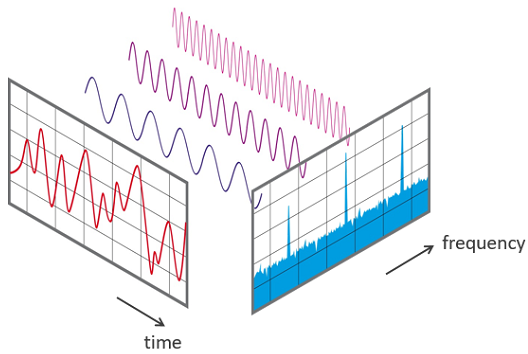

http://librosa.org/doc/main/generated/librosa.stft.html

STFT의 단순히 magnitude 부분을 취해서 db스케일로만 변환해주면 spectrogram이 된다. 

즉, stft은 복소수로 리턴되므로 np.abs를 이용해서 amplitude로 바꿔준다.   
librosa.amplitude_to_db()를 이용해 stft을 dB 스케일로 바꿔주면 스펙트로그램이 된다. 

STFT에서 시간과 FFT는 다음과 같은 관계가 있습니다. STFT의 시간 차원은 보통 윈도우 크기를 결정하는 n_fft를 이용하여 조절합니다.

- n_fft가 작을수록 STFT의 시간 축 해상도가 높아집니다. 즉, STFT는 짧은 시간 동안 주파수 정보를 캡처할 수 있습니다.
- n_fft가 클수록 STFT의 주파수 축 해상도가 높아집니다. 즉, STFT는 더 넓은 주파수 범위를 캡처할 수 있습니다.


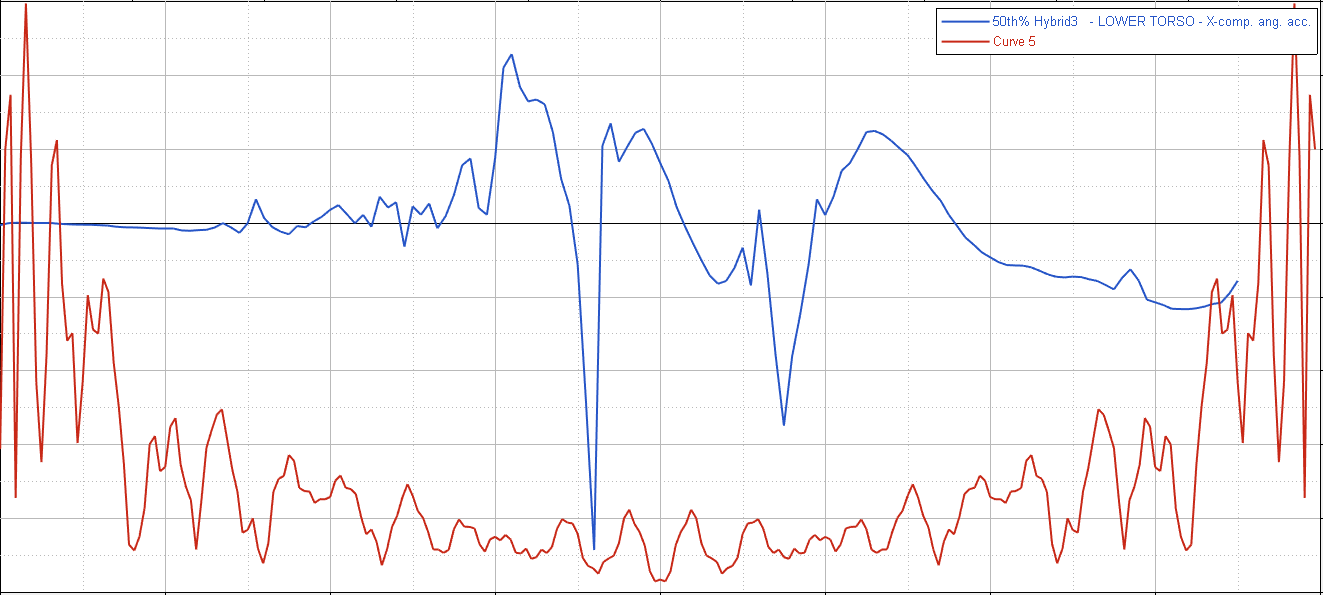

In [ ]:
D = librosa.stft(audio[0], n_fft = 2048)

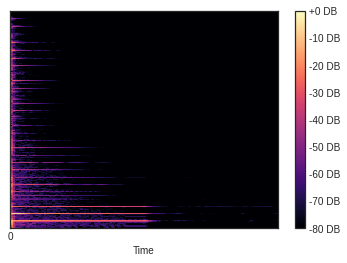

In [ ]:
# 절댓값으로 변경
D = np.abs(D)

D = librosa.amplitude_to_db(D, ref = np.max)

librosa.display.specshow(D, x_axis= 'time')
plt.colorbar(format = '%+2.0f DB')
plt.xticks(range(0, 1))
plt.show()

In [ ]:
def wav2spec(wav, fft_size = 2048): 
    D = np.abs(librosa.stft(wav, n_fft=fft_size)) # output size = (1 + n_fft/2, t)
    return D

In [ ]:
# shape check 
print(audio_np[0].shape)
print(wav2spec(audio_np[0]).shape)

(88200,)
(1025, 173)


In [ ]:
# 전체 데이터에 stft 적용 
audio_spec = []
for a in audio:
    audio_spec.append(wav2spec(a)) 

In [ ]:
# numpy 변환
spec_np = np.array(audio_spec, np.float32)
inst_np = np.array(inst, np.int16)

print(spec_np.shape, inst_np.shape)

(500, 1025, 173) (500,)


### Modeling

In [ ]:
spec_X = spec_np.reshape(500, )
spec_X.shape

(500, 177325)

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(spec_X, inst_np, test_size = 0.2)

In [ ]:
LR = LogisticRegression()
LR.fit(train_x, train_y)

In [ ]:
LR.score(train_x, train_y), LR.score(test_x, test_y)

(0.92, 0.57)

In [ ]:
RF = RandomForestClassifier()
RF.fit(train_x, train_y)
RF.score(train_x, train_y), RF.score(test_x, test_y)

(0.92, 0.81)

왜 이런 결과가 나올까요? 

* 오디오 데이터를 spectrogram으로 가공하면 파장과 세기를 가진 이미지(2차원 배열)가 생성
* 이 spectrogram을 CNN 이미지 분류를 통해 각 악기 소리를 분류

### DNN 모델 구성

In [ ]:
train_x.shape

(400, 177325)

In [ ]:
from keras.models import Sequential 
from keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(256, input_shape = (177325, ),activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation = 'relu')) 
model.add(Dropout(0.5))
model.add(Dense(10, activation = 'softmax'))

model.compile(
    loss = 'sparse_categorical_crossentropy', 
    optimizer = 'adam',
    metrics = ['acc']
)

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 256)               45395456  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 10)                1290      
                                                                 
Total params: 45,429,642
Trainable params: 45,429,642
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fitting
model.fit(train_x, train_y, epochs = 50, batch_size = 128, validation_split = 0.2)

Epoch 1/50
3/3 [==============================] - 1s 248ms/step - loss: 0.9812 - acc: 0.7125 - val_loss: 2.6846 - val_acc: 0.5750
Epoch 2/50
3/3 [==============================] - 0s 173ms/step - loss: 1.0445 - acc: 0.6781 - val_loss: 2.6493 - val_acc: 0.6000
Epoch 3/50
3/3 [==============================] - 0s 168ms/step - loss: 0.8380 - acc: 0.7250 - val_loss: 2.5952 - val_acc: 0.6125
Epoch 4/50
3/3 [==============================] - 0s 185ms/step - loss: 0.9620 - acc: 0.6906 - val_loss: 2.5833 - val_acc: 0.5875
Epoch 5/50
3/3 [==============================] - 0s 92ms/step - loss: 0.8732 - acc: 0.7031 - val_loss: 2.5806 - val_acc: 0.6000
Epoch 6/50
3/3 [==============================] - 0s 127ms/step - loss: 0.8295 - acc: 0.7312 - val_loss: 2.5771 - val_acc: 0.5875
Epoch 7/50
3/3 [==============================] - 0s 94ms/step - loss: 0.8280 - acc: 0.7437 - val_loss: 2.6001 - val_acc: 0.5750
Epoch 8/50
3/3 [==============================] - 0s 99ms/step - loss: 1.1581 - acc: 0.7188 

In [ ]:
def plot_history(history_dict):
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(loss)+1)
    fig = plt.figure(figsize=(14, 5))

    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(epochs, loss, 'b--', label = 'train_loss')
    ax1.plot(epochs, val_loss, 'r--', label = 'val_loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.grid()
    ax1.legend()

    acc = history_dict['acc']
    val_acc = history_dict['val_acc']

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(epochs, acc, 'b--', label = 'train_acc')
    ax2.plot(epochs, val_acc, 'r--', label = 'val_acc')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.grid()
    ax2.legend()

    plt.show()

In [ ]:
plot_history(history.history)

In [ ]:
model.evaluate(test_x, test_y)

4/4 [==============================] - 0s 21ms/step - loss: 3.2220 - acc: 0.6300


[3.2220325469970703, 0.6299999952316284]

## MFCC를 이용한 머신러닝 오디오 분류

### 데이터 준비

* 데이터를 불러오고 MFCC(Mel-frequency cepstral coefficients)를 사용해 melspectrogram으로 변환

In [ ]:
sr

44100

In [ ]:
audio_mfcc = []

for a in audio_np :  
    audio_mfcc.append(np.abs(librosa.feature.mfcc(y = a, sr = sr)))

In [ ]:
# numpy array 변환 -> 2d -> 1d 
np.array(audio_mfcc).shape

(500, 20, 173)

### Decision Tree

## MFCC를 이용한 딥러닝 오디오 분류

* 앞선 문제점을 극복하기 위해 오디오 데이터에 특화된 분류 방법 필요
* 오디오 데이터를 spectrogram으로 가공하면 파장과 세기를 가진 이미지(2차원 배열)가 생성
* 이 spectrogram을 CNN 이미지 분류를 통해 각 악기 소리를 분류

### CNN 모델 구성



*   spectrogram을 분류할 DNN 모델 구성
*   모델의 구성은 여타 이미지 분류 모델과 다르지 않음
*   spectrogram은 1차원 이미지로 간주


In [ ]:
print(train_x.shape)

(400, 20, 173, 1)


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

input_shape = 20, 173, 1

model = Sequential([
  layers.Input(shape = input_shape),
  layers.Conv2D(32, 3, activation ='relu'),
  layers.MaxPooling2D(pool_size=(2,2), padding='same'),
  layers.Conv2D(64, 3, activation ='relu'),
  layers.MaxPooling2D(pool_size=(2,2), padding='same'),
  layers.Conv2D(128, 3, activation ='relu'),
  layers.MaxPooling2D(pool_size=(2,2), padding='same'),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(10, activation='softmax'),
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 18, 171, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 9, 86, 32)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 84, 64)         18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 42, 64)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 40, 128)        73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 20, 128)      

In [ ]:
model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
history = model.fit(train_x, train_y, epochs = 30, batch_size=128, validation_split=0.2)

Epoch 1/30
3/3 [==============================] - 2s 580ms/step - loss: 16.7498 - acc: 0.1250 - val_loss: 17.0171 - val_acc: 0.1375
Epoch 2/30
3/3 [==============================] - 2s 487ms/step - loss: 12.2968 - acc: 0.0906 - val_loss: 4.0656 - val_acc: 0.1500
Epoch 3/30
3/3 [==============================] - 2s 495ms/step - loss: 3.6492 - acc: 0.1281 - val_loss: 2.9572 - val_acc: 0.0750
Epoch 4/30
3/3 [==============================] - 2s 497ms/step - loss: 2.6449 - acc: 0.1469 - val_loss: 2.3323 - val_acc: 0.1000
Epoch 5/30
3/3 [==============================] - 2s 490ms/step - loss: 2.2330 - acc: 0.1875 - val_loss: 2.2975 - val_acc: 0.1000
Epoch 6/30
3/3 [==============================] - 2s 493ms/step - loss: 2.1871 - acc: 0.2000 - val_loss: 2.2083 - val_acc: 0.2375
Epoch 7/30
3/3 [==============================] - 2s 497ms/step - loss: 2.0647 - acc: 0.2906 - val_loss: 2.1302 - val_acc: 0.2250
Epoch 8/30
3/3 [==============================] - 2s 497ms/step - loss: 1.9493 - acc: 0

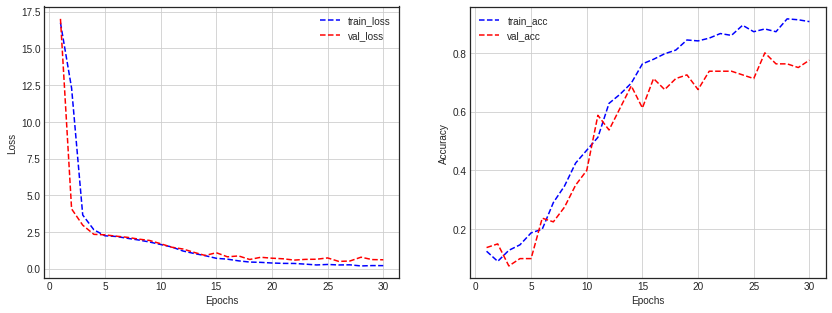

In [ ]:
plot_history(history.history)



*   훈련한 모델에 대한 정확도 평가
*   앞선 일반 분류 방법보다 정확도가 많이 오른 것을 확인할 수 있음



In [ ]:
model.evaluate(test_x, test_y)

4/4 [==============================] - 0s 31ms/step - loss: 0.3157 - acc: 0.8500


[0.3157031238079071, 0.8500000238418579]